# Overview

## Objectives

## Content

## Organisation

## Input

## Output

## Notes


In this notebook, we define a measure of urbanity for municipalities. First, we produce a composite score based the *Tranche d'aire urbaine* and *zonage en aire urbaine* in which the municipalities is located. Then, we take municipalities that belong to a larger *Tranches d'aires urbaines* of less than 100'000 inhabitants, and measure their distance to the nearest larger *Tranche d'aire urbaine*. Finally, we score these remaining municipalities according to a series of distance thresholds.

In [1]:
import requests
import pathlib
import zipfile
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from os import path
import shapely
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import urllib.request
import io

# Input data

## Geometric data

### Metropolitan France municipal geometry

First, we input municipal borders in metropolitan France from *data.gouv.fr*.

In [2]:
""" Metropolitan France municipal geographical boundaries
    Dataset name: Communes France métropole 
    Data provider: data.gouv.fr
    Documentation: https://www.data.gouv.fr/en/datasets/communes-france-metropole/
    Location (permalink): https://www.data.gouv.fr/en/datasets/r/ddffa579-1ec4-4f54-bd4d-edb00aa09f1c
"""
municipal_geo_file = '../data/datagouv-gis-france_metro_municipalities.geojson'

if path.exists(municipal_geo_file):
    print('Loading geometry from local file...')
    municipal_geo = gpd.read_file(municipal_geo_file)
else:
    print('Loading geometry from remote...')
    url = 'https://www.data.gouv.fr/en/datasets/r/ddffa579-1ec4-4f54-bd4d-edb00aa09f1c'
    municipal_geo = gpd.read_file(url)
    municipal_geo = municipal_geo.to_crs('epsg:2154')
municipal_geo.head()

Loading geometry from local file...


gml_id   CODE                  LIBELLE  \
0  COMMUNE.01001  01001  L'ABERGEMENT-CLEMENCIAT   
1  COMMUNE.01002  01002    L'ABERGEMENT-DE-VAREY   
2  COMMUNE.01004  01004        AMBERIEU-EN-BUGEY   
3  COMMUNE.01005  01005      AMBERIEUX-EN-DOMBES   
4  COMMUNE.01006  01006                  AMBLEON   

                                            geometry  
0  MULTIPOLYGON (((851129.600 6563369.200, 851107...  
1  MULTIPOLYGON (((888109.700 6545455.900, 888077...  
2  MULTIPOLYGON (((886593.000 6540886.000, 886567...  
3  MULTIPOLYGON (((850413.200 6544061.000, 850356...  
4  MULTIPOLYGON (((899820.100 6520340.200, 900065...

To check if the geodata is coherent with what we want, and to verify the projection, we plot the geometries. 

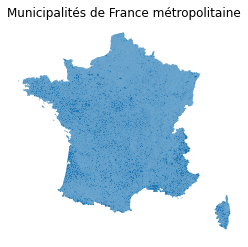

In [5]:
""" Plot France municipal geographical boundaries """
fig, ax = plt.subplots()
municipal_geo.plot(ax=ax)
plt.title("Municipalités de France métropolitaine")
ax.axis('off')
plt.show()

In [7]:
""" Output municipal boundaries """
if path.exists(municipal_geo_file):
    pass
else:
    municipal_geo.to_file(municipal_geo_file, driver='GeoJSON')

### Metropolitan France geometry

In [3]:
""" Metropolitan France geographical boundaries
    Dataset name: France 
    Data provider: 
    Location (permalink): https://opendata.arcgis.com/datasets/622c243da54e48fea23f8eb92e875c77_77.geojson
"""
france_geo_file = '../data/datagouv-gis-france_metro_country.geojson'
if path.exists(france_geo_file):
    france_geo = gpd.read_file(france_geo_file)
else:
    url = 'https://opendata.arcgis.com/datasets/622c243da54e48fea23f8eb92e875c77_77.geojson'
    france_geo = gpd.read_file(url)
    france_geo = france_geo.to_crs('epsg:2154')

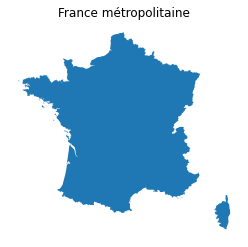

In [8]:
""" Plot France geographical boundaries """
fig, ax = plt.subplots()
france_geo.plot(ax=ax)
plt.title("France métropolitaine")
ax.axis('off')
plt.show()

In [28]:
""" Output municipal boundaries """
if path.exists(france_geo_file):
    pass
else:
    france_geo.to_file(france_geo_file, driver='GeoJSON')

## Urban Areas data

Second, we input data from INSEE about urban areas.

> Une aire urbaine ou "grande aire urbaine" est un ensemble de communes, d'un seul tenant et sans enclave, constitué par un pôle urbain (unité urbaine) de plus de 10 000 emplois, et par des communes rurales ou unités urbaines (couronne périurbaine) dont au moins 40 % de la population résidente ayant un emploi travaille dans le pôle ou dans des communes attirées par celui-ci.

> Le zonage en aires urbaines 2010 distingue également :

> * les "moyennes aires", ensemble de communes, d'un seul tenant et sans enclave, constitué par un pôle (unité urbaine) de 5 000 à 10 000 emplois, et par des communes rurales ou unités urbaines dont au moins 40 % de la population résidente ayant un emploi travaille dans le pôle ou dans des communes attirées par celui-ci.
> * les "petites aires", ensemble de communes, d'un seul tenant et sans enclave, constitué par un pôle (unité urbaine) de 1 500 à 5 000 emplois, et par des communes rurales ou unités urbaines dont au moins 40 % de la population résidente ayant un emploi travaille dans le pôle ou dans des communes attirées par celui-ci.

> Les aires urbaines, datées de 2010, ont été établies en référence à la population connue au recensement de 2008.

Source: INSEE. *Base des aires urbaines*. Online: https://www.insee.fr/fr/information/2115011. 

### Urban area ranks (*Tranches d'aires urbaines*)

INSEE ranks *Tranches d'aires urbaines* into 11 levels: 

* 00: Commune hors aire urbaine
* 01: Commune appartenant à une aire urbaine de moins de 15 000 habitants
* 02: Commune appartenant à une aire urbaine de 15 000 à 19 999 habitants
* 03: Commune appartenant à une aire urbaine de 20 000 à 24 999 habitants
* 04: Commune appartenant à une aire urbaine de 25 000 à 34 999 habitants
* 05: Commune appartenant à une aire urbaine de 35 000 à 49 999 habitants
* 06: Commune appartenant à une aire urbaine de 50 000 à 99 999 habitants
* 07: Commune appartenant à une aire urbaine de 100 000 à 199 999 habitants
* 08: Commune appartenant à une aire urbaine de 200 000 à 499 999 habitants
* 09: Commune appartenant à une aire urbaine de 500 000 à 9 999 999 habitants
* 10: Commune appartenant à l'aire urbaine de Paris 

We use two tables (sheets) from the file. We first input the list of  from an INSEE spreedsheet. In the table, we find four variable:

* **AU2010**: INSEE code of the *aire urbaine* as defined in 2010;
* **LIBAU2010**: label of this *aire urbaine*;
* **TAU2017**: *Tranche d'aire urbaine* as defined in 2017; and 
* **NB_COM**: number of municipalities included in the *aire urbaine*.

In [4]:
""" List Urban Areas
    Dataset name: Base des aires urbaines
    Data provider: INSEE 
    Information: https://www.insee.fr/fr/information/2115011
"""
f = '../data/insee-data-AU2010-200101.xlsx'
urban_areas = pd.read_excel(f, sheet_name='AU2010', header=5)
urban_areas.head()

AU2010                                  LIBAU2010  TAU2017  NB_COM
0    000  Communes isolées hors influence des pôles        0    7006
1    001                                      Paris       10    1751
2    002                                       Lyon        9     498
3    003                Marseille - Aix-en-Provence        9      90
4    004                                   Toulouse        9     452

From this table, we look how many *Tranches d'aires urbaines* exist, how many *aires urbaines* exist, and how many municipalities belong to an *Aire urbaine*.

In [5]:
""" Number of geographical units """
pd.DataFrame.from_dict({"Urban areas":urban_areas.shape[0],
"Tranches d'aire urbaine":len(urban_areas['TAU2017'].unique()),
"Municipalities":urban_areas['NB_COM'].sum()}, orient='index', columns=['Count'])

Count
Urban areas                793
Tranches d'aire urbaine     11
Municipalities           34968

Here we create a series of variables that will later allow us to convert urban area codes with urban area ranks, and find corresponding municipalities.

### Urban areas zones (*Zonage en aires urbaines*)

Second, we input a list of all municipalities and their corresponding classification. 

Since 2010, INSEE classifies municipalities into 9 categories that relate to the size of their urban area and their position within the urban area: 

* 111 : Commune appartenant à un grand pôle (10 000 emplois ou plus)
* 112 : Commune appartenant à la couronne d'un grand pôle
* 120 : Commune multipolarisée des grandes aires urbaines
* 211 : Commune appartenant à un moyen pôle (5 000 à moins de 10 000 emplois)
* 212 : Commune appartenant à la couronne d'un moyen pôle
* 221 : Commune appartenant à un petit pôle (de 1 500 à moins de 5 000 emplois)
* 222 : Commune appartenant à la couronne d'un petit pôle
* 300 : Autre commune multipolarisée
* 400 : Commune isolée hors influence des pôles

In the table **Composition_communale**, we find the variable **CATAU2010**, which describes the urban area zone of each municipality.

Variables in this table are:

* **CODGEO**: INSEE code of the municipality;
* **LIBGEO**: Name of the municipality;
* **CATAU2010**: INSEE code of the *zone en aire urbaine* as defined in 2010;
* **DEP**: INSEE code of the department in which the municipality is located;
* **REG**: INSEE code of the region in which the municipality is located.

In [6]:
""" List Urban Areas Communes
    Dataset name: Base des aires urbaines
    Data provider: INSEE 
    Location: https://www.insee.fr/fr/information/2115011
"""
f = '../data/insee-data-AU2010-200101.xlsx'
ua_municipalities = pd.read_excel(f, sheet_name='Composition_communale', header=5)
ua_municipalities.head()

CODGEO                   LIBGEO AU2010                       LIBAU2010  \
0  01001  L'Abergement-Clémenciat    997  Multipolarisé des grands pôles   
1  01002    L'Abergement-de-Varey    002                            Lyon   
2  01004        Ambérieu-en-Bugey    002                            Lyon   
3  01005      Ambérieux-en-Dombes    002                            Lyon   
4  01006                  Ambléon    998             Autre multipolarisé   

   CATAEU2010 DEP  REG  
0         120  01   84  
1         112  01   84  
2         112  01   84  
3         112  01   84  
4         300  01   84

## Socio demographic data

In [7]:
""" Municipalities’ demographics
    Dataset name: POP6 – Population de 15 ans ou plus par sexe, âge et catégorie socioprofessionnelle
    Data provider: INSEE.fr
    Data location: https://www.insee.fr/fr/statistiques/fichier/4171341/BTT_TD_POP6_2016.zip
    Information: https://www.insee.fr/fr/statistiques/4171341?sommaire=4171351#consulter
"""
url = 'https://www.insee.fr/fr/statistiques/fichier/4171341/BTT_TD_POP6_2016.zip'
with urllib.request.urlopen(url) as r:
    municipal_demographics = pd.read_csv(io.BytesIO(r.read()),
                                         compression='zip',
                                         sep=';',
                                         header=0,
                                         dtype=str,
                                         encoding='latin-1')
municipal_demographics['NB'] = municipal_demographics['NB'].astype(float)
municipal_demographics.head()

NIVGEO CODGEO                        LIBGEO CS1_8 AGEQ65 SEXE   NB
0    ARM  13201  Marseille 1er Arrondissement     1    015    1  0.0
1    ARM  13201  Marseille 1er Arrondissement     1    015    2  0.0
2    ARM  13201  Marseille 1er Arrondissement     1    020    1  0.0
3    ARM  13201  Marseille 1er Arrondissement     1    020    2  0.0
4    ARM  13201  Marseille 1er Arrondissement     1    025    1  0.0

# Data Curation

## Conversion variables
Here, we combine the data from both tables (urban areas list and urban area municipalities) and create a series of conversion variables. We will later use these variables as “shorcuts” to manipulate the data.

In [8]:
""" Create objects to convert TAU2017 variable to other variables """
# NOT IN USE --> areas_to_municipalities = ua_municipalities.set_index('AU2010')['CODGEO'].to_dict()

# Dictionary to convert urban areas to urban area ranks
areas_to_ranks = urban_areas.set_index('AU2010')['TAU2017'].to_dict()

# Two-variable data frame: urban area ranks and municipalities codes
rank_municipality = pd.concat([ua_municipalities['AU2010'].replace(areas_to_ranks).rename('TAU2017'), ua_municipalities['CODGEO']], axis=1)

# Dictionary to convert urban area ranks to 
municipalities_to_ranks = rank_municipality.set_index('CODGEO')['TAU2017'].to_dict()

# Data frame listing all municipalities for each rank
ranks_municipalities = rank_municipality.groupby('TAU2017')['CODGEO'].apply(list)

# Two-variable data frame: urban area and municipalities codes
municipalities_areas = ua_municipalities[['CODGEO','AU2010']]

# Dictionary to convert municipalities to zones
municipalities_to_zones = ua_municipalities.set_index('CODGEO')['CATAEU2010'].to_dict()

# Two-variable data frame: urban area zones and municipalities codes
zone_municipalitiy = ua_municipalities[['CODGEO', 'CATAEU2010']]

In [9]:
""" Municipal population """
municipal_population = municipal_demographics.groupby('CODGEO')['NB'].sum().reset_index()
municipal_population.head()

CODGEO            NB
0  01001    605.000000
1  01002    195.000000
2  01004  11273.704757
3  01005   1374.056524
4  01006     90.000000

In [10]:
""" Urban areas populations """
urban_areas_population = municipal_population.set_index('CODGEO').join(municipalities_areas.set_index('CODGEO')).groupby('AU2010')['NB'].sum().reset_index()
urban_areas_population.head()

AU2010            NB
0    000  2.539692e+06
1    001  1.010110e+07
2    002  1.858911e+06
3    003  1.441580e+06
4    004  1.101886e+06

In [11]:
""" Two-variable data frame: municipality population and municipality area (sq.k) """
population_area = pd.concat([municipal_population.set_index('CODGEO'), municipal_geo.set_index('CODE')['geometry'].area.div(1000000)], axis=1).dropna()
population_area.columns = ['NB', 'area']
population_area.head()

NB       area
01001    605.000000  15.622686
01002    195.000000   9.175809
01004  11273.704757  24.509326
01005   1374.056524  16.013347
01006     90.000000   6.029655

# Processing data

## Measuring urbanity

Here, we attribute a measure of urbanity for each municipality based on the following score attribution table.
To compute the table's score, we proceed in four steps:
1. Score municipalities according to the size of their urban areas;
2. Score municipalities according to the urban area zoning;
3. Score municipalities according to their distance to urban areas of more than 100k inhabitants.

### Score municipalities by urban area size

To attribute scores based on the population size of urban areas, we input municipal population data from INSEE.

*Note*: In this data, the total population is 57M, which is 10M under 7M under its current 64.81M inhabitants.

The population data splits the number of inhabitants according to three variables: socioprofessional category (CS1_8), age group (AGEQ65) and gender (SEXE). To get a net population by municipality, we sum corresponding entries.

In [27]:
""" Input score table """
f = '../data/koseki-table-urban_area_score.csv'
area_size_score = pd.read_csv(f)
score_to_area_size = area_size_score.set_index('score').to_dict(orient='index')

In [28]:
""" Attribute points according to the size of the urban area rank 
    
    Note: This attributes scores to “multipolarized” (997 and 998) and ”isolated” (000) municipalities.
    We shall replace these scores later on.
"""
# Create series to host scores
ua_score = pd.DataFrame(data=0, index=list(ua_municipalities['CODGEO']), columns=['urban_area_score'])

# Compute score by urban area size
for score in score_to_area_size:
    vmin,vmax = score_to_area_size[score]['min'], score_to_area_size[score]['max']
    # Municipalities that belong to a urban area with given population range
    ua_idx = list(urban_areas_population[urban_areas_population['NB'].between(vmin, vmax, inclusive=True)]['AU2010'])
    # select municpalities corresponding to the urban area index
    muni_idx = list(ua_municipalities.set_index('AU2010').loc[ua_idx]['CODGEO'])
    ua_score.loc[muni_idx] = ua_score.loc[muni_idx]+score
    

# Reset scores for multipolarized or isolated municipalities (CATAEU2010 == [120, 300, 400]
ua_score.loc[list(ua_municipalities[ua_municipalities['CATAEU2010'].isin([120, 300, 400])]['CODGEO']), 'urban_area_score'] = 0

ua_score.head()

urban_area_score
01001                 0
01002                 2
01004                 2
01005                 2
01006                 0

### Score municipalities by urban area zoning

Next, we add points according to the municipality's location wihtin an urban area. For this, we rely on the INSEE classification of  municipalities in “Zonage en aire urbaine,” which describres three types of zones: central, first crown and multipolarized. In the data, this corresponds to the “CATAEU2010" variable, which takes up 9 values:

* 111 : Commune appartenant à un grand pôle (10 000 emplois ou plus)
* 112 : Commune appartenant à la couronne d'un grand pôle
* 120 : Commune multipolarisée des grandes aires urbaines
* 211 : Commune appartenant à un moyen pôle (5 000 à moins de 10 000 emplois)
* 212 : Commune appartenant à la couronne d'un moyen pôle
* 221 : Commune appartenant à un petit pôle (de 1 500 à moins de 5 000 emplois)
* 222 : Commune appartenant à la couronne d'un petit pôle
* 300 : Autre commune multipolarisée
* 400 : Commune isolée hors influence des pôles

In [29]:
""" Input score table """
f = '../data/koseki-table-area_zoning_score.csv'
zoning_score = pd.read_csv(f)
zone_to_score = zoning_score.set_index('zone')['score'].to_dict()

In [30]:
""" Score municipalities according to urban area zoning """
uaz_score = ua_municipalities[['CODGEO', 'CATAEU2010']].set_index('CODGEO').replace(zone_to_score)
uaz_score.columns=['zone_score']

We also want to differenciate between central municpality (the city) and the adjacent areas. The classification in urban area zone does not do this. For example, in the urban area of Paris, INSEE classify the municipality of Paris in the same category of surrounding municipalities of Pantin, Montreuil, Neuilly, etc. 

To reflect the more urban character of central municipalities, we remoce one point to municipalities at the center of the urban area. While the data does not specify the code of those municipalities, we use their name to select them. Indeed, the name of the central municipality corresponds to the name of the urban area.

In [31]:
""" Remove one point if the municipality if the core municipality of the urabn area """
# Select areas in urban poles (large, medium and large)
urban_poles = ua_municipalities[ua_municipalities['CATAEU2010'].isin(['111','211', '221'])]

# Select municipalities with the same name as urban area (center municipalities)
centers_idx = urban_poles[urban_poles['LIBGEO']==urban_poles['LIBAU2010']].set_index('CODGEO').index

# Remove score (-1) to these municipalities
uaz_score.loc[centers_idx] = uaz_score.loc[centers_idx] - 1

uaz_score.head()

zone_score
CODGEO            
01001            9
01002            2
01004            2
01005            2
01006            9

### Score municipalities by distance to large urban areas

#### Compute distance between municipalities and nearest large urban area

To measure the distance between every municipality and the nearest urban area rank, we split municipalities in two subsets: those within a given urban area rank and those outside. For example, if we set the threshold to 100'000 inhabitants, we split municipalities that belong to an urban area rank of 100'000 and more, and those that do not.

In [32]:
""" Select municipalities within a 100'000 urban area rank or above """
# Large urban areas (> 100k inhabitants) municipal codgeo
large_ua_municipalities = [i for l in ranks_municipalities.loc[[7,8,9,10]].to_list() for i in l]
# Large urban areas municipal geometry
large_ua_municipalities_geo = municipal_geo.set_index('CODE').reindex(large_ua_municipalities).dropna().geometry.values
# Large urban areas geometry
large_urban_areas_geo = shapely.geometry.MultiPolygon([i for l in large_ua_municipalities_geo for i in l])

# Remote muncipalities (outside large urban areas) codgeo
remote_municipalities = [i for l in ranks_municipalities.loc[[0,1,2,3,4,5,6]].to_list() for i in l]
# Remote muncipalities geometry
remote_municipalities_geo = municipal_geo.set_index('CODE').reindex(remote_municipalities).dropna().geometry

In [16]:
""" Compute distance betwen out municipalities and nearest urban area"""
# Check first if the data is available locally
distances_file = '../data/koseki-data-distance_to_urban_area_7to10.csv'
if path.exists(f):
    distances = pd.read_csv(distances_file)
     # Rename geometry variable as distance --> change this before output to csv
    distances.columns = ['CODE', 'distance']
else:
    distances = remote_municipalities_geo.apply(lambda x: x.distance(large_urban_areas_geo))
    distances = distances.reset_index()
    distances.name='distance'
    
distances.head()

CODE      distance
0  01079  10249.867063
1  01081   1742.371020
2  01187  10230.570720
3  01210      0.000000
4  01247      0.000000

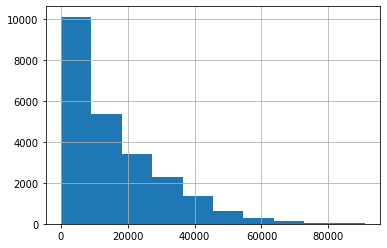

In [34]:
""" Plot distance data """
distances['distance'].hist()

In [35]:
""" Output distance data to csv file """
if path.exists(distances_file):
    pass
else:
    distances.to_csv(distances_file)

#### Score municipalities by distance to large urban area

In [36]:
""" Add points for distance to large urban area 
    Add 1 point if distance is between 20 and 50km, and 2 points if above 50km
"""
# Create series to host scores
distance_score = pd.DataFrame(data=0, index=list(ua_municipalities['CODGEO']), columns=['distance_score'])

# Add score for distance between 20 and 50km
idx = distances[distances['distance'].between(20000, 50000)].set_index('CODE').index
distance_score.loc[idx, 'distance_score'] += 1 

# Add score for distance more than 50km
idx = distances[distances['distance']>50000].set_index('CODE').index
distance_score.loc[idx, 'distance_score'] += 2

distance_score.head()

distance_score
01001               0
01002               0
01004               0
01005               0
01006               0

### Compile scores

In [37]:
""" Compile scores """
urban_score_file = '../data/koseki-data-urban_score.csv'
if path.exists(urban_score_file):
    urban_score = pd.read_csv(urban_score_file, index_col=0).iloc[:,0]
else:
    urban_score = pd.concat([ua_score, uaz_score, distance_score], axis=1).sum(axis=1)
    urban_score.name='urban_score'
    urban_score.reset_index()
    urban_score.columns = ['CODEGEO', 'urban_score']
    urban_score.head()

In [29]:
""" Output urban score """
if path.exists(urban_score_file):
    pass
else:
    urban_score.to_csv(urban_score_file)

## Benchmark

In this section, we benchmark our measure of urbanity against other institutional or conceptual measures:
* INSEE Tranches en aires urbaines
* INSEE Zones en aires urbaines
* INSEE new measure (ask JL)
* Population density
* Building density

To benchmark these different measures, we look at how they concentrate socioprofessional activities from the *CS1_8* variable, which classify socioprofessional activities in 8 categories.

To illustrate the benchmarking, we plot heatmaps, in which the $x$ axis represent the 8 categories of the *CS1_8* variable, and the $y$ axis represents the classification of each measure of urbanity.

### Municipality distribution
Here, we count the number of municipalities by index category for:
* Urban area ranks
* Urban area zones
* Urban density quantiles
* Urban score (our measure)

#### ... for urban area ranks

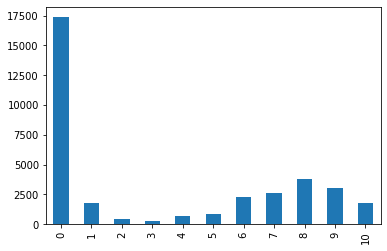

In [30]:
""" Number of municipalities by urban area rank """
ranks_muncipal_count = rank_municipality['TAU2017'].value_counts().sort_index()
ranks_muncipal_count.plot.bar()

In [31]:
""" Output urban area ranks municipal count """
def output_csv(data, filepath):
    if path.exists(filepath):
        pass
    else:
        data.to_csv(filepath)

f = '../data/koseki-data-ranks_municipal_count.csv'
output_csv(ranks_muncipal_count, f)

#### ... for urban area zones

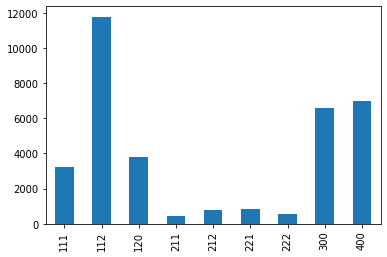

In [32]:
""" Number of municipalities by urban area zones """
zones_muncipal_count = ua_municipalities['CATAEU2010'].value_counts().sort_index()
zones_muncipal_count.plot.bar()

f = '../data/koseki-data-zones_muncipal_count.csv'
output_csv(zones_muncipal_count, f)

#### ... for urban density quantiles

In [34]:
""" Population density by sq.km """
municipal_area = municipal_geo['geometry'].area / 1000000
municipal_area.name = 'area'
municipal_area.index = municipal_geo['CODE']
municipal_density = municipal_population.set_index('CODGEO')['NB'].divide(municipal_area).dropna()
municipal_density.head()

01001     38.725734
01002     21.251531
01004    459.976119
01005     85.806956
01006     14.926226
dtype: float64

##### Original density measures

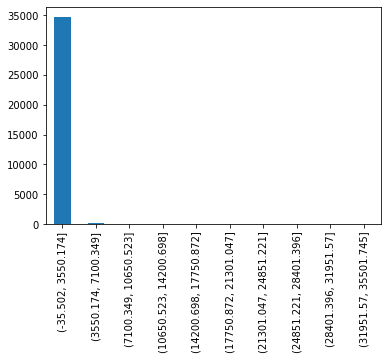

In [35]:
""" Number of municipalities by density segments (10) """
municipal_density_quantiles = pd.cut(municipal_density, 10)
municipal_density_quantiles.rename('quantiles')
density_municipal_count = municipal_density_quantiles.value_counts().sort_index()
density_municipal_count.plot.bar()

f = '../data/koseki-data-density_municipal_count.csv'
output_csv(density_municipal_count, f)

##### Log density measures

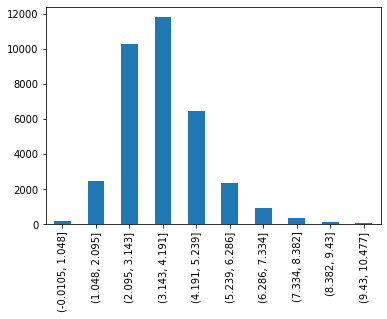

In [36]:
""" Log number of municipalities by density segments (10) """
municipal_log_density = municipal_density.apply(lambda x: np.log(x+1))
municipal_log_density_quantiles = pd.cut(municipal_log_density, 10)
log_density_municipal_count = municipal_log_density_quantiles.value_counts().sort_index()
log_density_municipal_count.plot.bar()

f = '../data/koseki-data-log_density_municipal_count.csv'
output_csv(log_density_municipal_count, f)

#### ... for urban score

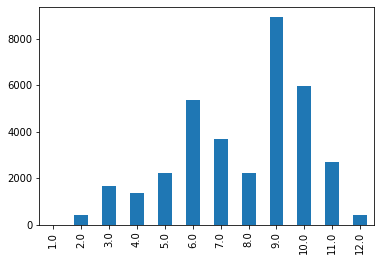

In [37]:
score_muncipal_count = urban_score.value_counts().sort_index()
score_muncipal_count.plot.bar()

f = '../data/koseki-data-score_muncipal_count.csv'
output_csv(score_muncipal_count, f)

### Population distribution
Here we count the number of inhabitants by index category

#### ... for urban area ranks

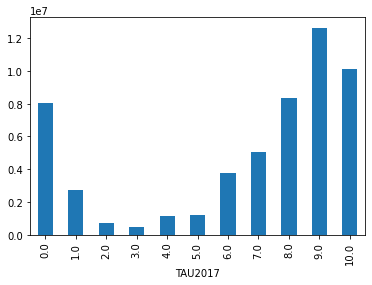

In [38]:
ranks_population = municipal_population.copy()
ranks_population['TAU2017'] = ranks_population['CODGEO'].map(municipalities_to_ranks)
ranks_population = ranks_population.groupby('TAU2017')['NB'].sum()
ranks_population.plot.bar()

f = '../data/koseki-data-ranks_population.csv'
output_csv(ranks_population, f)

#### ... for urban area zones

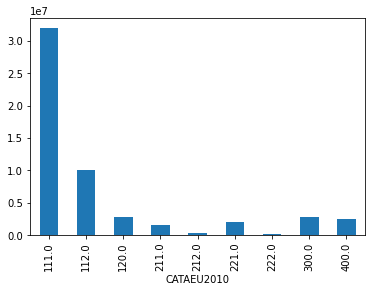

In [39]:
zones_population = municipal_population.copy()
zones_population['CATAEU2010'] = zones_population['CODGEO'].map(municipalities_to_zones)
zones_population = zones_population.groupby('CATAEU2010')['NB'].sum()
zones_population.plot.bar()

f = '../data/koseki-data-zones_population.csv'
output_csv(zones_population, f)

#### ... for urban density quantiles

##### Original density measure

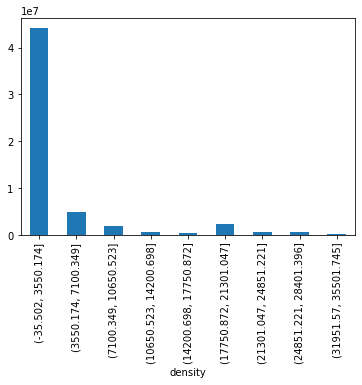

In [40]:
density_population = municipal_population.copy()
municipalities_to_density_quantiles = municipal_density_quantiles.to_dict()
density_population['density'] = density_population['CODGEO'].map(municipalities_to_density_quantiles)
density_population = density_population.groupby('density')['NB'].sum()
density_population.plot.bar()

f = '../data/koseki-data-density_population.csv'
output_csv(density_population, f)

##### Log density measure

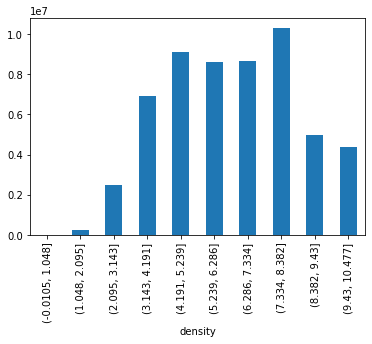

In [41]:
log_density_population = municipal_population.copy()
municipalities_to_log_density_quantiles = municipal_log_density_quantiles.to_dict()
log_density_population['density'] = log_density_population['CODGEO'].map(municipalities_to_log_density_quantiles)
log_density_population = log_density_population.groupby('density')['NB'].sum()
log_density_population.plot.bar()

f = '../data/koseki-data-log_density_population.csv'
output_csv(log_density_population, f)

#### ... for urban measure

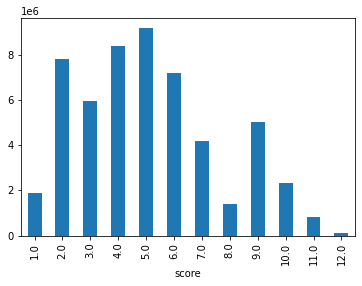

In [42]:
score_population = municipal_population.copy()
municipalities_to_score = urban_score.to_dict()
score_population['score'] = score_population['CODGEO'].map(municipalities_to_score)
score_population = score_population.groupby('score')['NB'].sum()
score_population.plot.bar()

f = '../data/koseki-data-score_population.csv'
output_csv(score_population, f)

### Socioeconomic classes distribution

In [43]:
def socioeconomic_shares(demographics, category, converter):
    """ Returns a table with shares of socioeconomic profiles by urban categories 
    """
    demographics[category] = demographics['CODGEO'].map(converter)
    demographics.dropna(subset=[category], inplace=True)
    category_socioeconomic = demographics.groupby([category, 'CS1_8'])['NB'].sum().reset_index()
    category_socioeconomic_table = category_socioeconomic.pivot_table(index='CS1_8', columns=category, values='NB')
    category_socioeconomic_table_share = category_socioeconomic_table.divide(category_socioeconomic_table.sum(axis=0))
    return category_socioeconomic_table_share

#### ... for urban area ranks

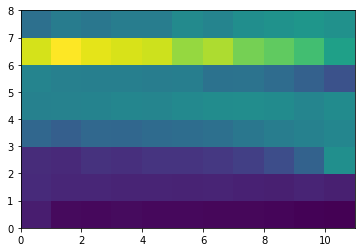

In [44]:
""" Share of socioeconomic profiles by urban area ranks """
ranks_socioeconomic_table_share = socioeconomic_shares(municipal_demographics, 'TAU2017', municipalities_to_ranks)
plt.pcolor(ranks_socioeconomic_table_share)

f = '../data/koseki-data-ranks_socioeconomic_table_share.csv'
output_csv(ranks_socioeconomic_table_share, f)

#### ... for urban area zones

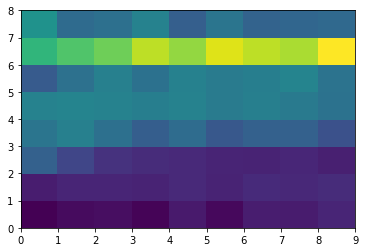

In [45]:
""" Share of socioeconomic profiles by urban area zones """
zones_socioeconomic_table_share = socioeconomic_shares(municipal_demographics, 'CATAEU2010', municipalities_to_zones)
plt.pcolor(zones_socioeconomic_table_share)

f = '../data/koseki-data-zones_socioeconomic_table_share.csv'
output_csv(zones_socioeconomic_table_share, f)

#### ... for urban density quantiles

##### Original density

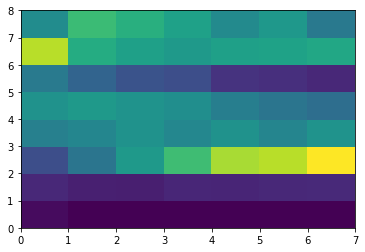

In [46]:
density_socioeconomic_table_share = socioeconomic_shares(municipal_demographics, 'quantiles', municipalities_to_density_quantiles)
plt.pcolor(density_socioeconomic_table_share)

f = '../data/koseki-data-density_socioeconomic_table_share.csv'
output_csv(density_socioeconomic_table_share, f)

##### Log density

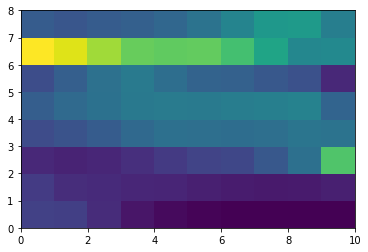

In [47]:
log_density_socioeconomic_table_share = socioeconomic_shares(municipal_demographics, 'quantiles', municipalities_to_log_density_quantiles)
plt.pcolor(log_density_socioeconomic_table_share)

f = '../data/koseki-data-log_density_socioeconomic_table_share.csv'
output_csv(log_density_socioeconomic_table_share, f)

#### ... for urban measure

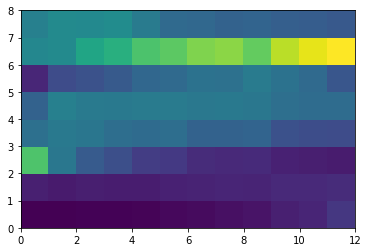

In [48]:
score_socioeconomic_table_share = socioeconomic_shares(municipal_demographics, 'score', municipalities_to_score)
plt.pcolor(score_socioeconomic_table_share)

f = '../data/koseki-data-score_socioeconomic_table_share.csv'
output_csv(score_socioeconomic_table_share, f)

### Population density distribution

In [50]:
def density_by_category(population, variable, converter):
    """
    Returns population density by square kilometers by value
    """
    density = population.copy()
    density[variable] = density.index.map(converter)
    density = density.groupby(variable).apply(lambda x: x['NB'].sum() / x['area'].sum())
    return density

#### ... for urban area rank

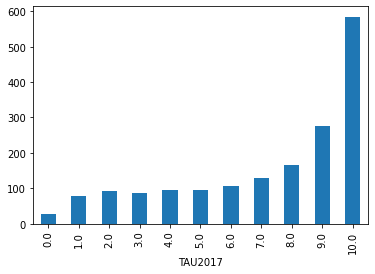

In [51]:
ranks_density = density_by_category(population_area, 'TAU2017', municipalities_to_ranks)
ranks_density.plot.bar()

f = '../data/koseki-data-ranks_density.csv'
output_csv(ranks_density, f)

#### ... for urban area zone

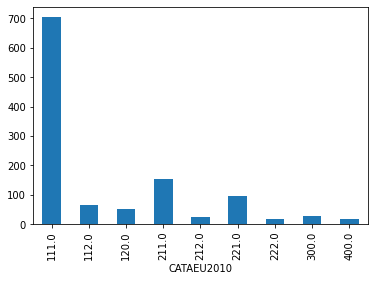

In [52]:
zone_density = density_by_category(population_area, 'CATAEU2010', municipalities_to_zones)
zone_density.plot.bar()

f = '../data/koseki-data-zone_density.csv'
output_csv(zone_density, f)

#### ... for urban density quantiles

##### Original density

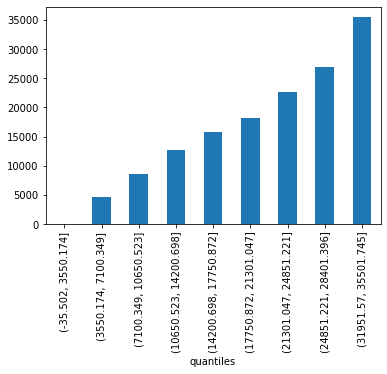

In [53]:
density_density = density_by_category(population_area, 'quantiles', municipalities_to_density_quantiles)
density_density.plot.bar()

f = '../data/koseki-data-density_density.csv'
output_csv(density_density, f)

##### Log density

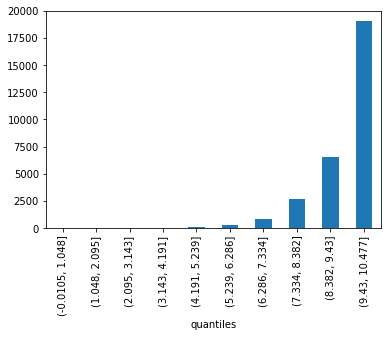

In [54]:
log_density_density = density_by_category(population_area, 'quantiles', municipalities_to_log_density_quantiles)
log_density_density.plot.bar()

f = '../data/koseki-data-log_density_density.csv'
output_csv(log_density_density, f)

#### ... for urban measure

##### Original density

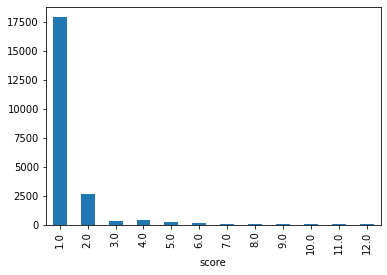

In [55]:
score_density = density_by_category(population_area, 'score', municipalities_to_score)
score_density.plot.bar()

f = '../data/koseki-data-score_density.csv'
output_csv(score_density, f)

##### Log density

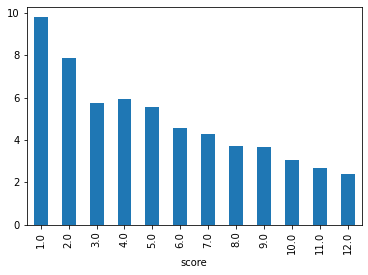

In [56]:
log_score_density = score_density.apply(lambda x: np.log(x))
log_score_density.plot.bar()

f = '../data/koseki-data-log_score_density.csv'
output_csv(log_score_density, f)

In [ ]:
""" UNDER WORK --> """

### Surface area distribution

In [17]:
municipal_population

CODGEO            NB
0      01001    605.000000
1      01002    195.000000
2      01004  11273.704757
3      01005   1374.056524
4      01006     90.000000
...      ...           ...
34993  97420  17495.094485
34994  97421   5545.718560
34995  97422  59245.032998
34996  97423   5586.391067
34997  97424   4184.544273

[34998 rows x 2 columns]

In [57]:
population_area

NB       area
01001    605.000000  15.622686
01002    195.000000   9.175809
01004  11273.704757  24.509326
01005   1374.056524  16.013347
01006     90.000000   6.029655
...             ...        ...
95676    379.288331   8.325885
95678    720.000000   9.857103
95680  20232.574051   7.319052
95682    176.796610   3.245392
95690    295.000000   8.480219

[34886 rows x 2 columns]

In [59]:
population_area.index.map(municipalities_to_ranks)

Float64Index([ 0.0,  9.0,  9.0,  9.0,  0.0,  9.0,  9.0,  2.0,  0.0,  5.0,
              ...
              10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0],
             dtype='float64', length=34886)

In [70]:
def area_by_category(population, variable, converter):
    """
    Returns area by category
    """
    area = population.copy()
    area[variable] = area.index.map(converter)
    area = area.groupby(variable)['area'].sum()
    return area

#### ... for urban area rank

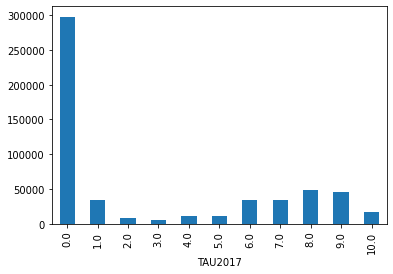

In [78]:
ranks_area = area_by_category(population_area, 'TAU2017', municipalities_to_ranks)
ranks_area.plot.bar()

f = '../data/koseki-data-ranks_area.csv'
output_csv(ranks_area, f)

#### ... for urban area zone

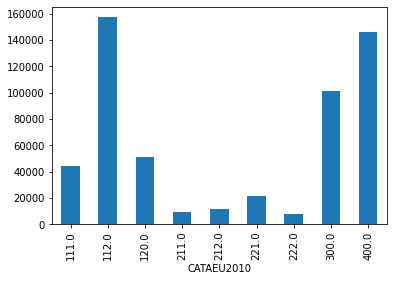

In [82]:
zones_area = area_by_category(population_area, 'CATAEU2010', municipalities_to_zones)
zones_area.plot.bar()

f = '../data/koseki-data-zones_area.csv'
output_csv(zones_area, f)

#### ... for urban density quantiles

##### Original density

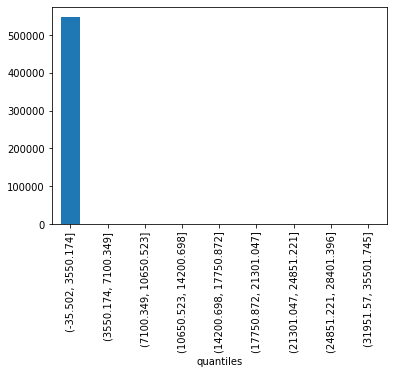

In [83]:
density_area = area_by_category(population_area, 'quantiles', municipalities_to_density_quantiles)
density_area.plot.bar()

f = '../data/koseki-data-density_area.csv'
output_csv(density_area, f)

##### Log density

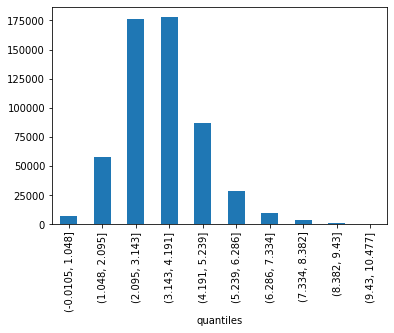

In [84]:
log_density_area = area_by_category(population_area, 'quantiles', municipalities_to_log_density_quantiles)
log_density_area.plot.bar()

f = '../data/koseki-data-log_density_area.csv'
output_csv(log_density_area, f)

#### ... for urban measure

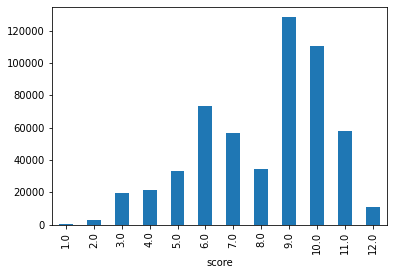

In [85]:
score_area = area_by_category(population_area, 'score', municipalities_to_score)
score_area.plot.bar()

f = '../data/koseki-data-score_area.csv'
output_csv(score_area, f)

# Visualizing data

## Maps

In [33]:
def plot_categorical_map(data, column, cmap, title, notes):
    """ Test Plot map info """
    
    fig, ax = plt.subplots(figsize=(5,5), dpi=150)
    
    # Contour
    france_geo.plot(ax=ax, facecolor='whitesmoke', edgecolor='k', linewidth=0.1)

    # Main data
    data.plot(ax=ax, column=column, cmap=cmap, categorical=True, legend=True, legend_kwds={'fontsize': 4, 'markerscale':.5, 'frameon':False, 'loc':'center left'})
        
    # Title
    plt.title(title, fontsize=8, loc='left')

    # Notes
    plt.text(x=0, y=6000000, s=notes, fontsize=5)

    ax.axis('off')
    plt.show()

In [104]:
def plot_continuous_map(data, column, cmap, title, notes):
    """ Test Plot map info """
    
    fig, ax = plt.subplots(figsize=(5,5), dpi=300)
    
    # Title
    plt.title(title, fontsize=8, loc='left')
    
    # Notes
    plt.text(x=0, y=6000000, s=notes, fontsize=5)
    
    # Contour
    france_geo.plot(ax=ax, facecolor='whitesmoke', edgecolor='k', linewidth=0.1)

    # Main data
    data.plot(ax=ax, column=column, cmap=cmap)
    
    vmin = data[column].min()
    vmax = data[column].max()
    
    # add colorbar
    fig = ax.get_figure()
    cax = fig.add_axes([0.135, .3, .02, .25])
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    # fake up the array of the scalar mappable. Urgh...
    sm._A = []
    cbar = fig.colorbar(sm, cax=cax)
    cbar.ax.tick_params(labelsize=5, width=0.1)
    cbar.outline.set_linewidth(0.1)
    
    ax.axis('off')
    plt.show()

### Urban area ranks
Using the data we have input, we visualize the geographical distribution of the urban area rank unto a map.

Insee classifies urban area into 11 ranks, in which rank 0 corresponds to municipalities outside urban areas and rank 10 corresponds to Paris municipality.

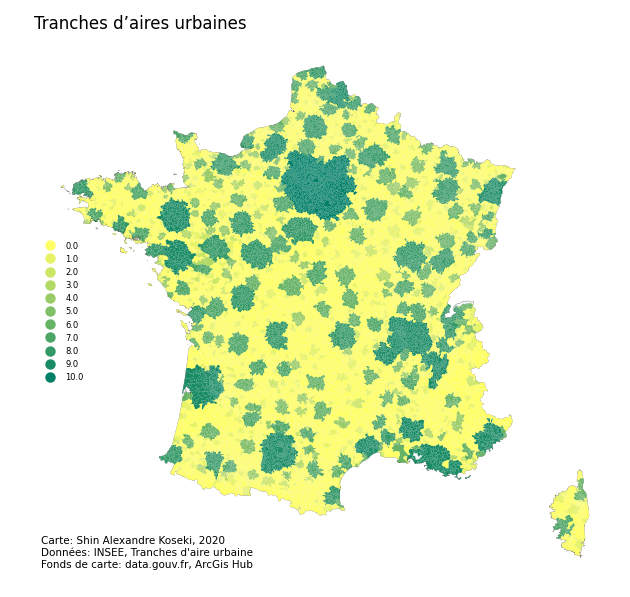

In [13]:
""" Plot urban area ranks for each municipality """

## !— >> Reverse legend order
## !— >> Replace legend item names by zone names using dict?

data = municipal_geo.set_index('CODE').join(rank_municipality.set_index('CODGEO'))
column = 'TAU2017'
cmap = 'summer_r'
title = 'Tranches d’aires urbaines'
notes = """
        Carte: Shin Alexandre Koseki, 2020
        Données: INSEE, Tranches d'aire urbaine
        Fonds de carte: data.gouv.fr, ArcGis Hub
        """
plot_categorical_map(data, column, cmap, title, notes)

### Urban area zones

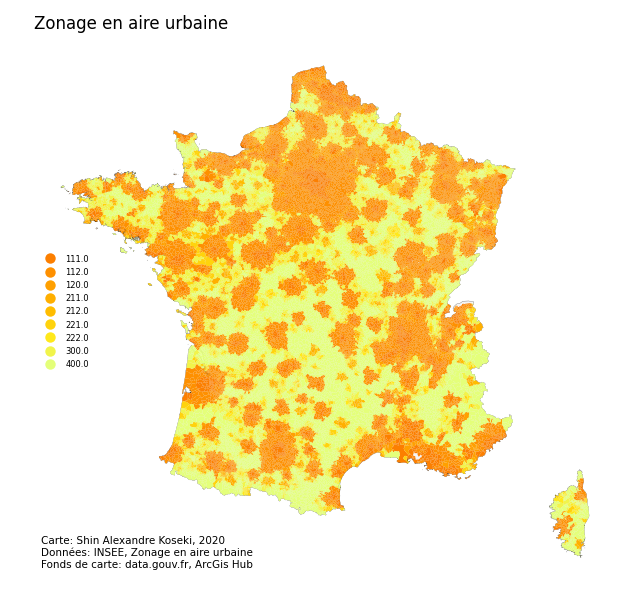

In [123]:
""" Plot urban area zone for each municipality """

## !— >> Replace legend item names by zone names using dict?

data = municipal_geo.set_index('CODE').join(zone_municipalitiy.set_index('CODGEO'))
column = 'CATAEU2010'
cmap = 'Wistia_r'
title = 'Zonage en aire urbaine'
notes = """
        Carte: Shin Alexandre Koseki, 2020
        Données: INSEE, Zonage en aire urbaine
        Fonds de carte: data.gouv.fr, ArcGis Hub
        """
plot_categorical_map(data, column, cmap, title, notes)

### Distance to large urban area

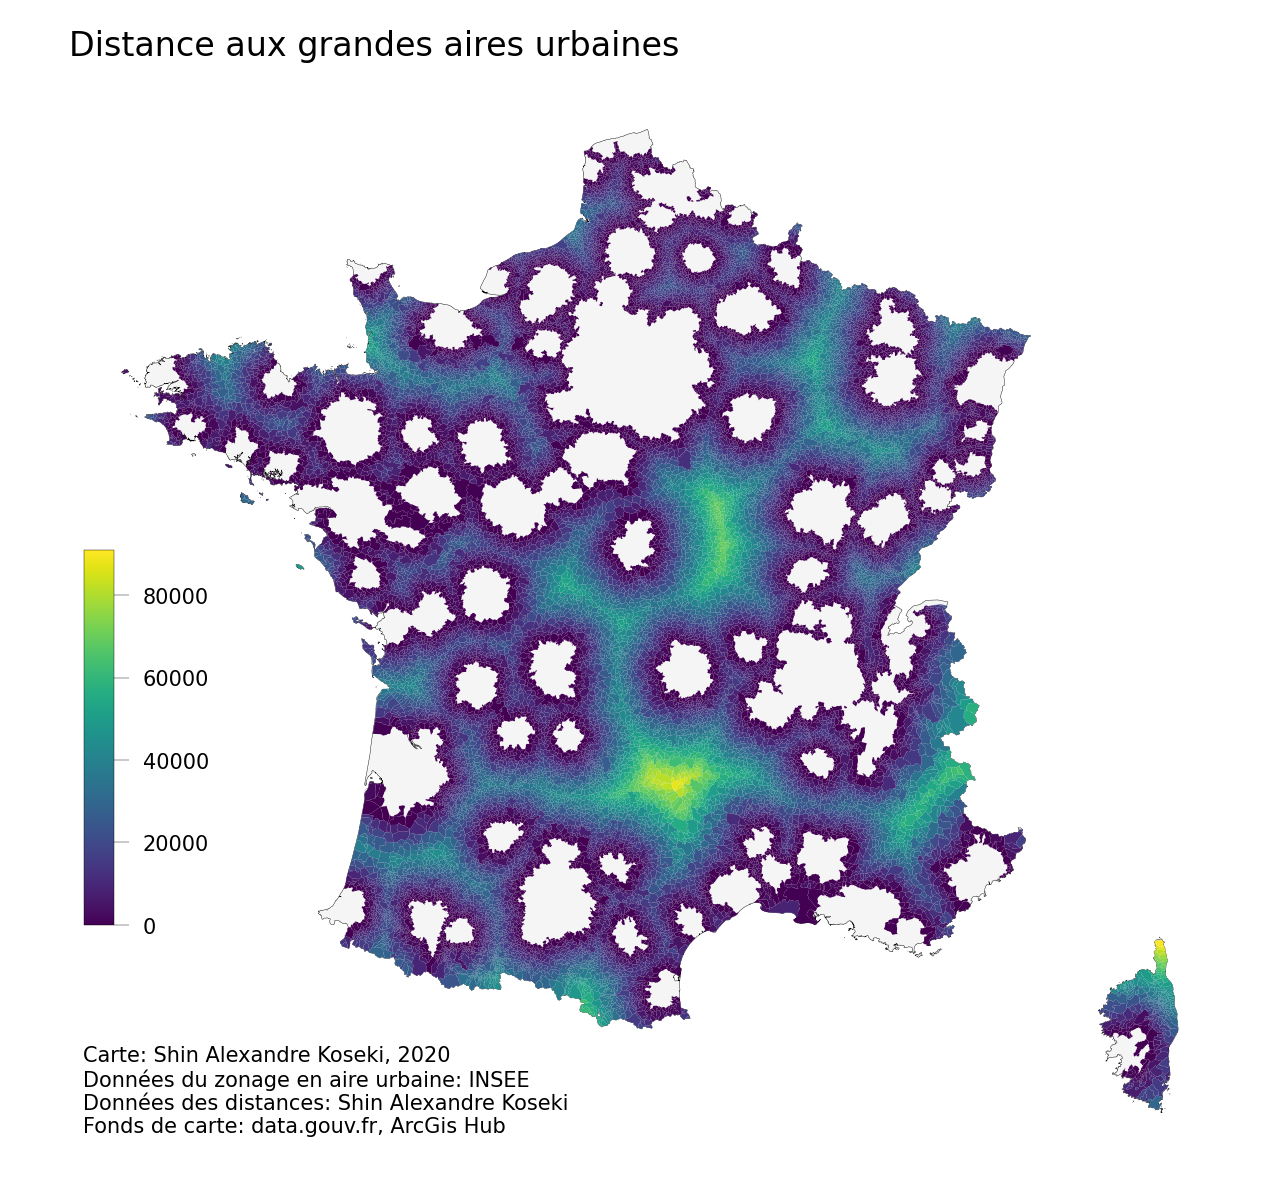

In [105]:
""" Plot distance to urban area of 100k or more """
## --> Convert distances to KM
## --> Introduce legend title "KM"

data = municipal_geo.set_index('CODE').join(distances.set_index('CODE'))
column = 'distance'
cmap = 'viridis'
title = 'Distance aux grandes aires urbaines'
notes = """
        Carte: Shin Alexandre Koseki, 2020
        Données du zonage en aire urbaine: INSEE
        Données des distances: Shin Alexandre Koseki
        Fonds de carte: data.gouv.fr, ArcGis Hub
        """
plot_continuous_map(data, column, cmap, title, notes)

In [20]:
data.head()

gml_id                  LIBELLE  \
CODE                                            
01001  COMMUNE.01001  L'ABERGEMENT-CLEMENCIAT   
01002  COMMUNE.01002    L'ABERGEMENT-DE-VAREY   
01004  COMMUNE.01004        AMBERIEU-EN-BUGEY   
01005  COMMUNE.01005      AMBERIEUX-EN-DOMBES   
01006  COMMUNE.01006                  AMBLEON   

                                                geometry  distance  
CODE                                                                
01001  MULTIPOLYGON (((851129.600 6563369.200, 851107...       0.0  
01002  MULTIPOLYGON (((888109.700 6545455.900, 888077...       NaN  
01004  MULTIPOLYGON (((886593.000 6540886.000, 886567...       NaN  
01005  MULTIPOLYGON (((850413.200 6544061.000, 850356...       NaN  
01006  MULTIPOLYGON (((899820.100 6520340.200, 900065...       0.0

NameError: name 'communes' is not defined

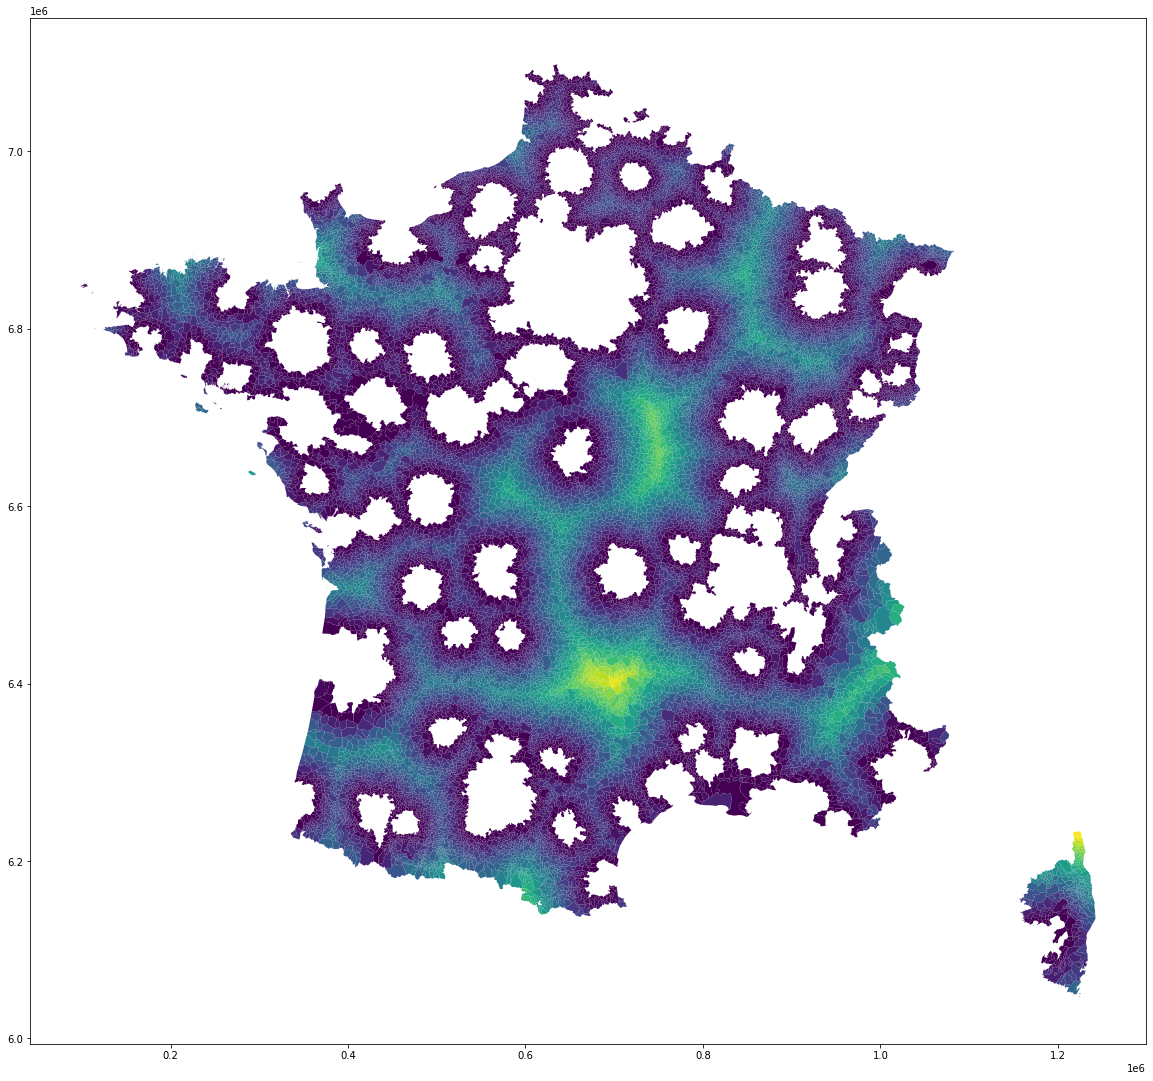

In [21]:
""" Plot map of distance to urban area above 100 k inhabitants """
data = municipal_geo.set_index('CODE').join(distances.set_index('CODE'))

fig, ax = plt.subplots(figsize=(20,20))

data.plot(ax=ax, column='distance', cmap='viridis')
# Map urban areas
communes.set_index('CODE').reindex(in_ua_muni_idx).dropna().plot(ax=ax, color='whitesmoke')

france.plot(ax=ax, facecolor='none', edgecolor='k', linewidth=0.1)

plt.title("Distance Euclidienne à une aire urbaine de plus de 100'000 habitants")
ax.axis('off')

### Mapping score by urban area rank

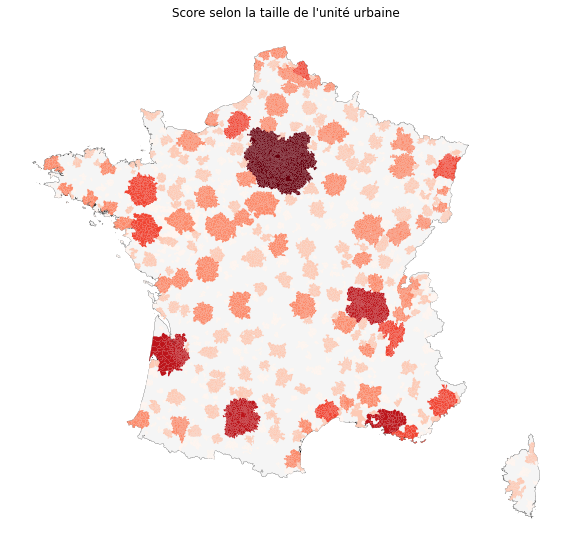

In [100]:
""" Plot map of ua_scores """
data = municipal_geo.set_index('CODE').join(ua_score)
data['urban_area_score'] = data['urban_area_score'].replace(0, np.nan)
data.dropna(subset=['urban_area_score'], inplace=True)

fig, ax = plt.subplots(figsize=(10,10))

france_geo.plot(ax=ax, facecolor='whitesmoke', edgecolor='k', linewidth=0.2)
data.plot(ax=ax, column='urban_area_score', cmap='Reds_r')


plt.title("Score selon la taille de l'unité urbaine")
ax.axis('off')
plt.show()

### Mapping score by urban area zone

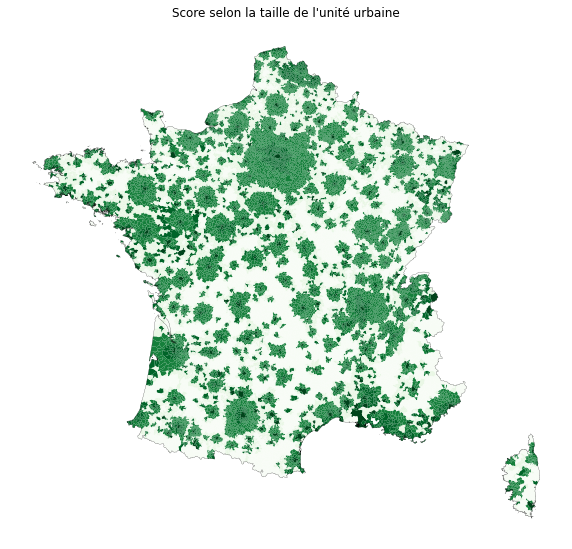

In [109]:
""" Plot map of ua_scores """
data = communes.set_index('CODE').join(uaz_score)
data.dropna(subset=['urban_area_score'], inplace=True)

fig, ax = plt.subplots(figsize=(10,10))

data.plot(ax=ax, column='urban_area_score', cmap='Greens_r')
france.plot(ax=ax, facecolor='none', edgecolor='k', linewidth=0.2)

plt.title("Score selon la taille de l'unité urbaine")
ax.axis('off')
plt.show()

### Mapping score by distance to large urban area

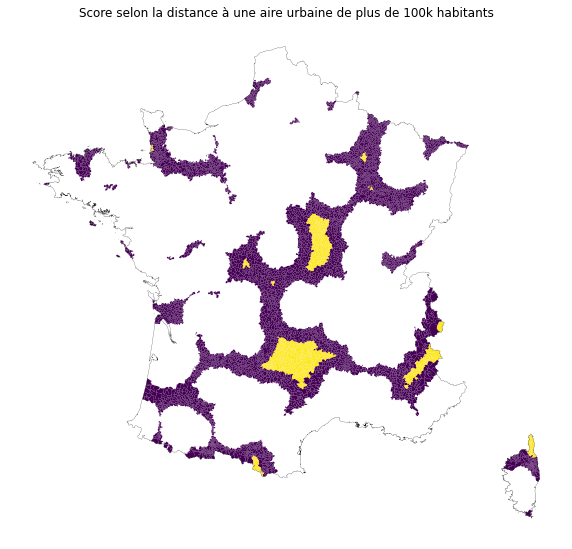

In [233]:
""" Plot map of distance score """
data = communes.set_index('CODE').join(distance_score)
data['distance_score'] = data['distance_score'].replace(0, np.nan)
data.dropna(subset=['distance_score'], inplace=True)

fig, ax = plt.subplots(figsize=(10,10))

data.plot(ax=ax, column='distance_score')
france.plot(ax=ax, facecolor='whitesmoke', edgecolor='k', linewidth=0.2)

plt.title("Score selon la distance à une aire urbaine de plus de 100k habitants")
ax.axis('off')
plt.show()

### Mapping urban measure

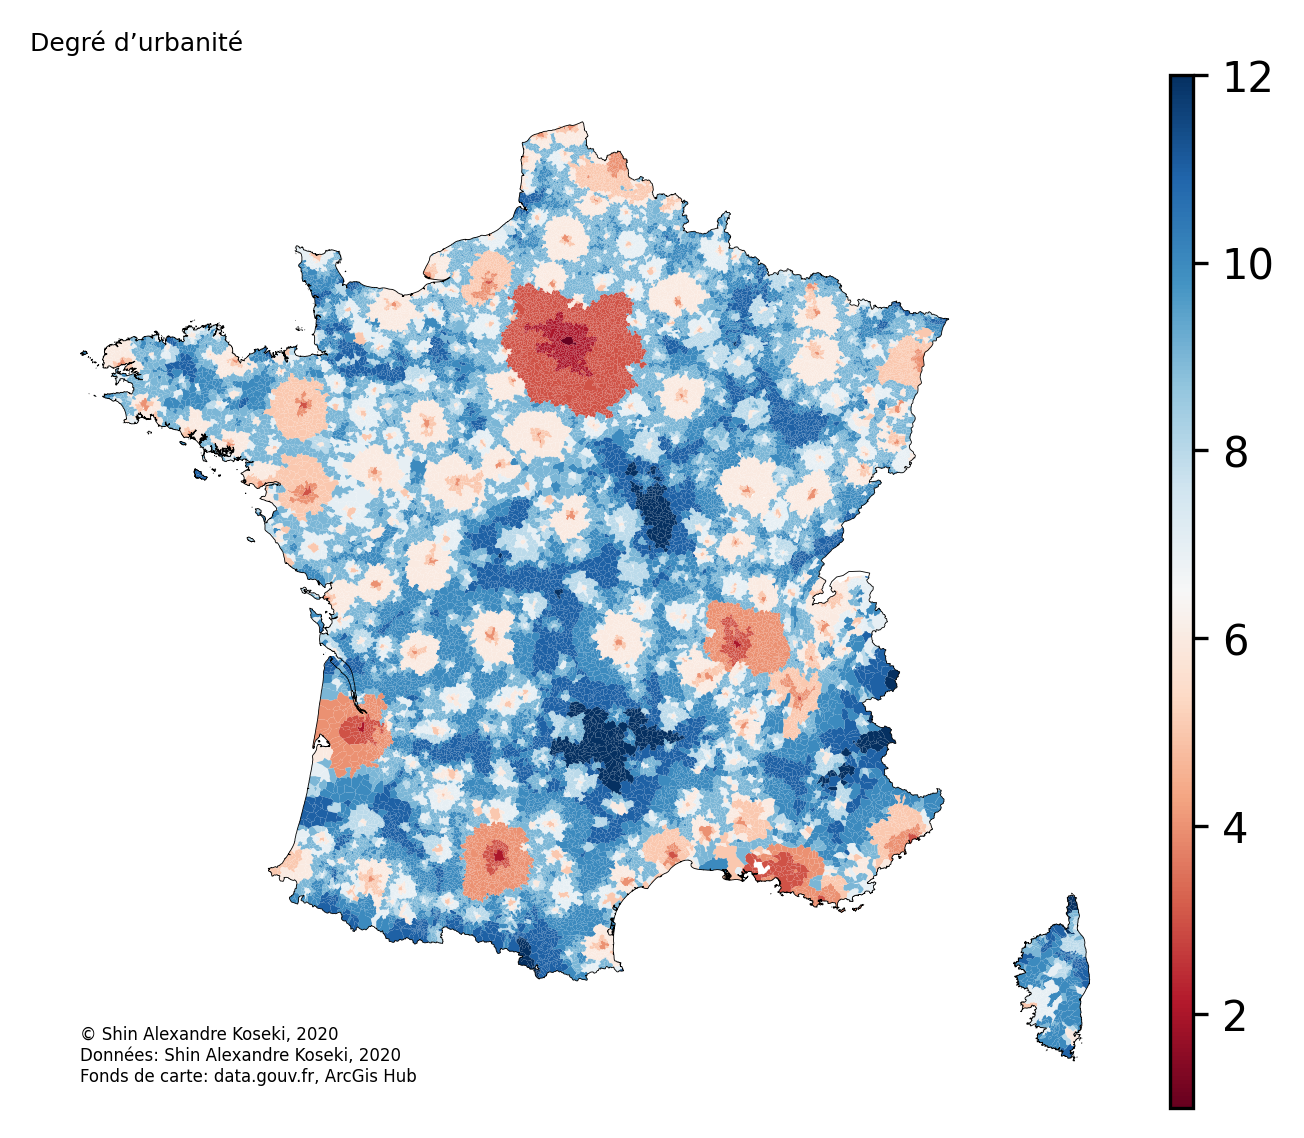

In [236]:
""" Plot map of distance to urban area above 100 k inhabitants """
data = communes.set_index('CODE').join(urban_score.set_index('CODGEO'))
data['urban_score'] = data['urban_score'].replace(0, np.nan)
data.dropna(subset=['urban_score'], inplace=True)

# Init plot
fig, ax = plt.subplots(figsize=(5,5), dpi=300)

# Title
plt.title("Degré d’urbanité", fontsize=6, loc='left')

# Notes
s = """
© Shin Alexandre Koseki, 2020
Données: Shin Alexandre Koseki, 2020
Fonds de carte: data.gouv.fr, ArcGis Hub
"""
ax.text(x=99047.004614, y=6000000, s=s, fontsize=4)

# Legend
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)

# Plot data
data.plot(ax=ax, column='urban_score', cmap='RdBu', legend=True, cax=cax)
france.plot(ax=ax, facecolor='none', edgecolor='k', linewidth=0.2)

ax.axis('off')
#plt.savefig('../output/koseki-map-urbanity_measure-200502.png')
plt.show()

## Visualizing benchmarks

In [286]:
""" Get full labels for urban area zones """
f = '../data/koseki-table-urban_area_zones_labels-200523.csv'
zones_labels = pd.read_csv(f, index_col=0).to_dict()['label']

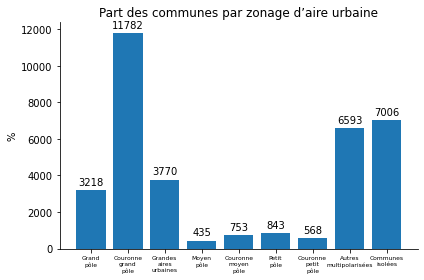

In [295]:
# Convert values to percentage integers
#data = (data / sum(data)) * 100

# Round data
data = [int(round(x)) for x in data]


# Plot share of municipalities
labels = labels
x = np.arange(len(labels))
width = 0.8

fig, ax = plt.subplots()
rects = ax.bar(x, data, width)

ax.set_ylabel('%')
ax.set_title("Part des communes par zonage d’aire urbaine")
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=6)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects)

fig.tight_layout()

plt.show()

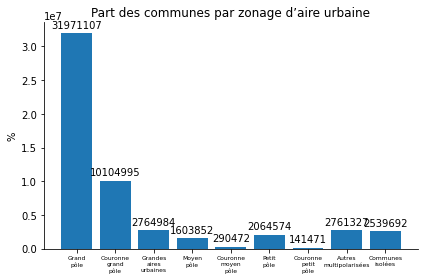

In [311]:
# Round data
data = [int(round(x)) for x in data]


# Plot share of municipalities
labels = labels
x = np.arange(len(labels))
width = 0.8

fig, ax = plt.subplots()
rects = ax.bar(x, data, width)

ax.set_ylabel('%')
ax.set_title("Population des zonages en aires urbaines")
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=6)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects)

fig.tight_layout()

plt.show()

### Visualizing municipal distributions

### Visualizing population distribution

### Visualizing socioprofessional distribution

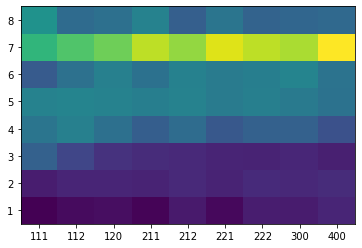

In [78]:
""" Plot share of socioprofessional composition of each urban area zone """
df = pd.DataFrame(uaz_socioeconomic_share_by_category)

plt.pcolor(df)
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
plt.show()

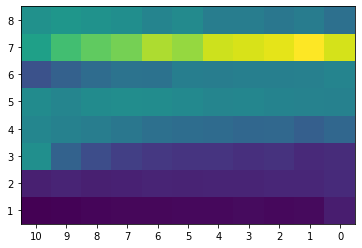

In [120]:
""" Plot share of socioprofessional composition of each urban area ranks """
df = pd.DataFrame(uar_socioeconomic_share_by_category)

# Reverse column order to get the largest ranks on the left
df = df[df.columns[::-1]]

plt.pcolor(df)
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
plt.show()

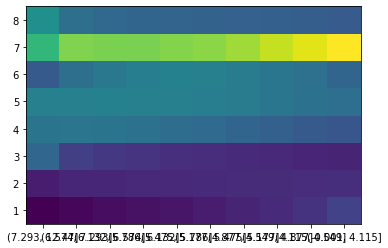

In [115]:
""" Plot share of socioprofessional composition of each population density quantile """
df = pd.DataFrame(quantile_socioeconomic_share_by_quantile)

# Reverse column order to get most density quartiles on the left end
df = df[df.columns[::-1]]

plt.pcolor(df)
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
plt.show()

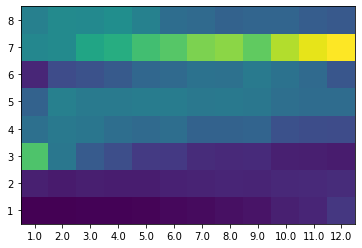

In [90]:
""" Plot share of socioprofessional composition of each urban score """
df = pd.DataFrame(score_socioeconomic_share_by_score)

plt.pcolor(df)
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
plt.show()